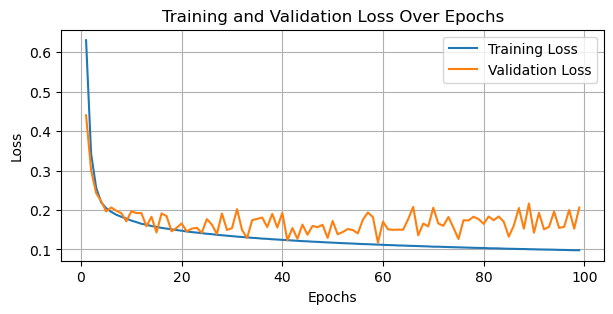

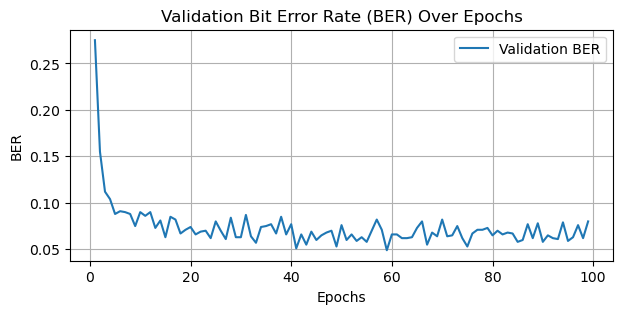

In [18]:
import pandas as pd
import matplotlib.pyplot as plt

# Load CSV data
csv_path = 'data/performance_details.csv'
df = pd.read_csv(csv_path)

# Plot Training Loss and Validation Loss
plt.figure(figsize=(7, 3))
plt.plot(df['Epoch'], df['Training Loss'], label='Training Loss')
plt.plot(df['Epoch'], df['Validation Loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss Over Epochs')
plt.grid(True)
plt.show()

# Plot Validation BER
plt.figure(figsize=(7, 3))
plt.plot(df['Epoch'], df['Validation BER'], label='Validation BER')
plt.xlabel('Epochs')
plt.ylabel('BER')
plt.legend()
plt.title('Validation Bit Error Rate (BER) Over Epochs')
plt.grid(True)
plt.show()